# Genpact Hackathon - Food Delivery Order Forecasting - Model
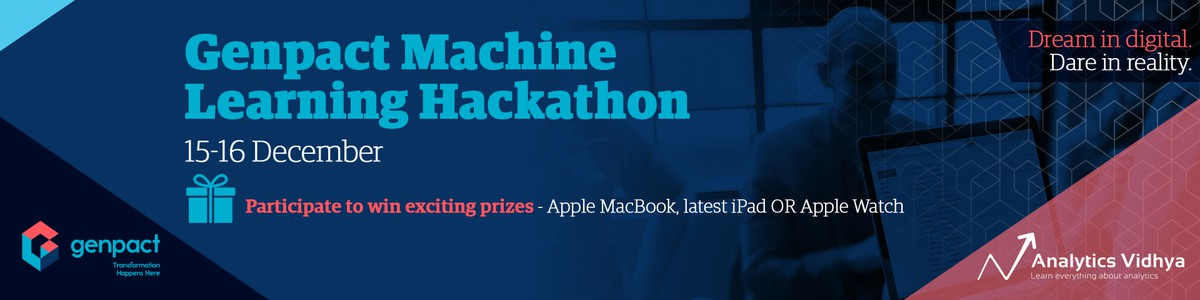

<B>Approach For Model Building:</B>
1. We start with the normalization of data. I tried Standard Scaler, Normalizer. Standard Scaler gave better result.
2. Feature Selection: The Exploratory data analysis and feaure engineering resulted in adding 90+ features and getting the overall dataset to be 100+ features. Its important to reduce dimentionality of dataset and select best features. I tried with Random Forest and LGBM. LGBM gave better result and selected 30 best features. Alternate approach could have been to use PCA.
3. Model Selection: After dimentionality reduction, the next step is to choose the best model. I fed the data to 9 models and selected best 4 models - LGBM, Catboost, Random Forest, XG Boost. I will now make the development of model with cross validation on each of these 4 models.
4. Wisdom of crowd is better that a single individual. The same approach is utilised by getting prediction from 4 different models and stacking them. Finally, getting the Ramdom Forest to make prediction on the output of the 4 models.

In [1]:
import os
os.chdir('D:/Shikhar/Coding/Hackathon/Genpact_ML_hackathon')
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
% matplotlib inline
import math
import seaborn as sns
from sklearn.cross_validation import train_test_split

from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

C:\Users\Anupam\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Anupam\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
col_dtypes = {'id': np.object, 'center_id': np.object, 'meal_id': np.object, 'city_code': np.object}
train_dataset = pd.read_csv ('Dataset/train_EDA.csv', dtype = col_dtypes)
test_dataset = pd.read_csv('Dataset/test_EDA.csv', dtype = col_dtypes)

stack_train = pd.DataFrame(train_dataset[['id', 'num_orders']])
stack_test = pd.DataFrame(test_dataset.id)
train_dataset.head(1)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,pct_num_orders_through_email_promotion,pct_num_orders_through_homepage_featured,center_id_meal_id_confRate,center_id_city_code_confRate,center_id_region_code_confRate,center_id_center_type_confRate,center_id_category_confRate,center_id_cuisine_confRate,meal_id_city_code_confRate,meal_id_region_code_confRate,meal_id_center_type_confRate,meal_id_category_confRate,meal_id_cuisine_confRate,city_code_region_code_confRate,city_code_center_type_confRate,city_code_category_confRate,city_code_cuisine_confRate,region_code_center_type_confRate,region_code_category_confRate,region_code_cuisine_confRate,center_type_category_confRate,center_type_cuisine_confRate,category_cuisine_confRate,price_bin,week_center_id_count_meal_id,week_center_id_count_city_code,week_center_id_count_region_code,week_center_id_count_center_type,week_center_id_count_category,week_center_id_count_cuisine,center_id_meal_id_count_city_code,center_id_meal_id_count_region_code,center_id_meal_id_count_center_type,center_id_meal_id_count_category,center_id_meal_id_count_cuisine,week_center_id_mean_meal_id,week_center_id_mean_city_code,week_center_id_mean_region_code,center_id_meal_id_mean_city_code,center_id_meal_id_mean_region_code,week_nunique_center_id,week_nunique_meal_id,week_nunique_city_code,week_nunique_region_code,week_nunique_center_type,week_nunique_category,week_nunique_cuisine,center_id_nunique_meal_id,center_id_nunique_city_code,center_id_nunique_region_code,center_id_nunique_center_type,center_id_nunique_category,center_id_nunique_cuisine,meal_id_nunique_city_code,meal_id_nunique_region_code,meal_id_nunique_center_type,meal_id_nunique_category,meal_id_nunique_cuisine,city_code_nunique_region_code,city_code_nunique_center_type,city_code_nunique_category,city_code_nunique_cuisine,region_code_nunique_center_type,region_code_nunique_category,region_code_nunique_cuisine,center_type_nunique_category,center_type_nunique_cuisine,category_nunique_cuisine,week_cumcount_center_id,week_cumcount_meal_id,week_cumcount_city_code,week_cumcount_region_code,week_cumcount_center_type,week_cumcount_category,week_cumcount_cuisine,center_id_cumcount_meal_id,center_id_cumcount_city_code,center_id_cumcount_region_code,center_id_cumcount_center_type,center_id_cumcount_category,center_id_cumcount_cuisine,meal_id_cumcount_city_code,meal_id_cumcount_region_code,meal_id_cumcount_center_type,meal_id_cumcount_category,meal_id_cumcount_cuisine,city_code_cumcount_region_code,city_code_cumcount_center_type,city_code_cumcount_category,city_code_cumcount_cuisine,region_code_cumcount_center_type,region_code_cumcount_category,region_code_cumcount_cuisine,center_type_cumcount_category,center_type_cumcount_cuisine,category_cumcount_cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,2,2.0,0,0,0.046242,0.393389,99.56,121.35,121.35,121.35,114.61,78.19,395.89,793.38,240.05,608.74,608.74,225.03,121.35,259.03,197.11,190.22,403.54,317.44,191.67,118.93,504.15,0,33,33,33,33,33,33,154,154,154,154,154,1996.848485,647,56,647,56,77,45,51,8,3,12,4,47,1,1,1,13,4,51,8,3,1,1,1,2,14,4,3,14,4,14,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Columns: 111 entries, id to category_cumcount_cuisine
dtypes: float64(28), int64(79), object(4)
memory usage: 386.6+ MB


In [5]:
label = train_dataset.num_orders
train_predictors = train_dataset.drop('num_orders', axis = 1).select_dtypes(exclude = ['object'])
test_predictors = test_dataset.select_dtypes(exclude = ['object'])

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Columns: 111 entries, id to category_cumcount_cuisine
dtypes: float64(28), int64(79), object(4)
memory usage: 386.6+ MB


### Normalize the data

In [7]:
from sklearn.preprocessing import StandardScaler
#Normalise the data with standard scalar
std_scale = StandardScaler().fit(train_predictors)
train_predictors1 = pd.DataFrame(std_scale.transform(train_predictors))
train_predictors1.columns  = train_predictors.columns
train_predictors = train_predictors1

test_predictors1 = pd.DataFrame(std_scale.transform(test_predictors))
test_predictors1.columns  = test_predictors.columns
test_predictors = test_predictors1
#print(pd.DataFrame(train_predictors))
train_predictors.head()

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,region_code,center_type,op_area,category,cuisine,pct_num_orders_through_email_promotion,pct_num_orders_through_homepage_featured,center_id_meal_id_confRate,center_id_city_code_confRate,center_id_region_code_confRate,center_id_center_type_confRate,center_id_category_confRate,center_id_cuisine_confRate,meal_id_city_code_confRate,meal_id_region_code_confRate,meal_id_center_type_confRate,meal_id_category_confRate,meal_id_cuisine_confRate,city_code_region_code_confRate,city_code_center_type_confRate,city_code_category_confRate,city_code_cuisine_confRate,region_code_center_type_confRate,region_code_category_confRate,region_code_cuisine_confRate,center_type_category_confRate,center_type_cuisine_confRate,category_cuisine_confRate,price_bin,week_center_id_count_meal_id,week_center_id_count_city_code,week_center_id_count_region_code,week_center_id_count_center_type,week_center_id_count_category,week_center_id_count_cuisine,center_id_meal_id_count_city_code,center_id_meal_id_count_region_code,center_id_meal_id_count_center_type,center_id_meal_id_count_category,center_id_meal_id_count_cuisine,week_center_id_mean_meal_id,week_center_id_mean_city_code,week_center_id_mean_region_code,center_id_meal_id_mean_city_code,center_id_meal_id_mean_region_code,week_nunique_center_id,week_nunique_meal_id,week_nunique_city_code,week_nunique_region_code,week_nunique_center_type,week_nunique_category,week_nunique_cuisine,center_id_nunique_meal_id,center_id_nunique_city_code,center_id_nunique_region_code,center_id_nunique_center_type,center_id_nunique_category,center_id_nunique_cuisine,meal_id_nunique_city_code,meal_id_nunique_region_code,meal_id_nunique_center_type,meal_id_nunique_category,meal_id_nunique_cuisine,city_code_nunique_region_code,city_code_nunique_center_type,city_code_nunique_category,city_code_nunique_cuisine,region_code_nunique_center_type,region_code_nunique_category,region_code_nunique_cuisine,center_type_nunique_category,center_type_nunique_cuisine,category_nunique_cuisine,week_cumcount_center_id,week_cumcount_meal_id,week_cumcount_city_code,week_cumcount_region_code,week_cumcount_center_type,week_cumcount_category,week_cumcount_cuisine,center_id_cumcount_meal_id,center_id_cumcount_city_code,center_id_cumcount_region_code,center_id_cumcount_center_type,center_id_cumcount_category,center_id_cumcount_cuisine,meal_id_cumcount_city_code,meal_id_cumcount_region_code,meal_id_cumcount_center_type,meal_id_cumcount_category,meal_id_cumcount_cuisine,city_code_cumcount_region_code,city_code_cumcount_center_type,city_code_cumcount_category,city_code_cumcount_cuisine,region_code_cumcount_center_type,region_code_cumcount_category,region_code_cumcount_cuisine,center_type_cumcount_category,center_type_cumcount_cuisine,category_cumcount_cuisine
0,-1.776494,-1.277687,-1.256048,-0.297187,-0.350123,-0.034837,1.663584,-1.9086,-1.120149,-1.32422,-0.775361,1.257815,-0.104980,-0.989397,-0.989397,-0.989397,-0.261607,-1.012253,2.050026,3.735626,0.320133,2.321645,2.321645,0.147535,-1.114151,0.727107,0.155283,-0.731213,1.223455,0.948107,-0.207,-1.552999,1.514618,-1.331525,-1.627976,-1.627976,-1.627976,-1.627976,-1.627976,-1.627976,0.545105,0.545105,0.545105,0.545105,0.545105,-0.807385,0.686548,-0.034837,0.686548,-0.034837,0.435088,-2.29243,0.0,0.0,0.0,-2.446979,0.0,-0.02799,0.0,0.0,0.0,0.106776,0.0,0.275406,0.276341,0.0,0.0,0.0,0.0,0.377372,1.003326,0.0,0.234057,0.974206,0.0,0.0,0.0,1.603075,-1.724023,-1.724023,-1.724023,-1.724023,-1.724023,-1.724023,-1.724023,-1.686547,-1.686547,-1.686547,-1.686547,-1.686547,-1.686547,-1.606141,-1.606141,-1.606141,-1.606141,-1.606141,-0.774042,-0.774042,-0.774042,-0.774042,-1.303313,-1.303313,-1.303313,-1.318073,-1.318073,-0.908488
1,-1.776494,-1.277687,-1.358465,-0.297187,-0.350123,-0.034837,1.663584,-1.9086,-1.120149,-1.32422,-0.741220,1.457747,-0.045941,-0.989397,-0.989397,-0.989397,-0.261607,-1.012253,1.669223,2.560587,0.176255,1.598879,1.598879,0.147535,

In [8]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Columns: 111 entries, id to category_cumcount_cuisine
dtypes: float64(28), int64(79), object(4)
memory usage: 386.6+ MB


In [9]:
X = train_predictors
y = label
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.33, random_state=89)

### Feature Selection

In [10]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [11]:
# define dataset
train_data = lgb.Dataset(X_train, label = y_train)
validate_data = lgb.Dataset(X_validate, label = y_validate, reference=train_data)

In [12]:
lgb_model = LGBMRegressor()
lgb_model.fit(X, y,
         eval_set=[(X_validate, y_validate)],
         eval_metric = 'mse',
         early_stopping_rounds = 10,
         verbose = False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

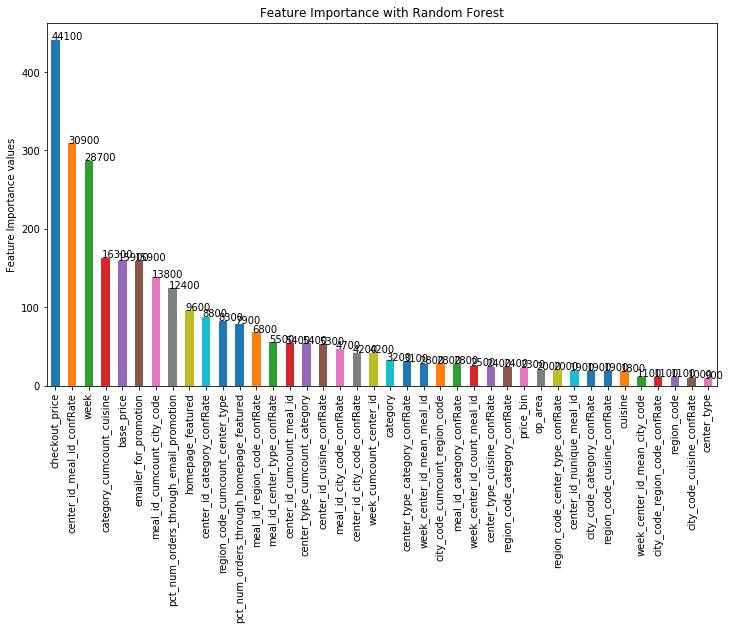

In [13]:
#lgb_model.booster_.feature_importance()
important_features = pd.Series(lgb_model.feature_importances_, index = train_predictors.columns).sort_values(ascending=False)
ax = important_features[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('Genpact Feature Importance.png')

#for getting the values on each bar
for i in ax.patches:
    ax.annotate(round(i.get_height()*100, 2), (i.get_x(), i.get_height()))

plt.show()

In [15]:
'''from sklearn.ensemble import RandomForestRegressor
X = train_predictors
y = label
model = RandomForestRegressor(n_estimators=100, random_state = 89, max_depth=5)
model.fit(train_predictors, label)
'''

'from sklearn.ensemble import RandomForestRegressor\nX = train_predictors\ny = label\nmodel = RandomForestRegressor(n_estimators=100, random_state = 89, max_depth=5)\nmodel.fit(train_predictors, label)\n'

In [16]:
'''# Plot the top 40 important features
important_features = pd.Series(model.feature_importances_, index = train_predictors.columns).sort_values(ascending=False)
ax = important_features[:30].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('Genpact Feature Importance.png')

#for getting the values on each bar
for i in ax.patches:
    ax.annotate(round(i.get_height()*100, 2), (i.get_x(), i.get_height()))

plt.show()
'''

"# Plot the top 40 important features\nimportant_features = pd.Series(model.feature_importances_, index = train_predictors.columns).sort_values(ascending=False)\nax = important_features[:30].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))\nplt.ylabel('Feature Importance values')\nplt.subplots_adjust(bottom=0.25)\nplt.savefig('Genpact Feature Importance.png')\n\n#for getting the values on each bar\nfor i in ax.patches:\n    ax.annotate(round(i.get_height()*100, 2), (i.get_x(), i.get_height()))\n\nplt.show()\n"

In [17]:
# Now select top 12 features in predictor datasetand discard other features
train_predictors = train_predictors[important_features.index[:30]]
test_predictors = test_predictors[important_features.index[:30]]
display(train_predictors.sample(10))
test_predictors.sample(10)

,checkout_price,center_id_meal_id_confRate,week,category_cumcount_cuisine,base_price,emailer_for_promotion,meal_id_cumcount_city_code,pct_num_orders_through_email_promotion,homepage_featured,center_id_category_confRate,region_code_cumcount_center_type,pct_num_orders_through_homepage_featured,meal_id_region_code_confRate,meal_id_center_type_confRate,center_id_cumcount_meal_id,center_type_cumcount_category,center_id_cuisine_confRate,meal_id_city_code_confRate,center_id_city_code_confRate,week_cumcount_center_id,category,center_type_category_confRate,week_center_id_mean_meal_id,city_code_cumcount_region_code,meal_id_category_confRate,week_center_id_count_meal_id,center_type_cuisine_confRate,region_code_category_confRate,price_bin,op_area
107954,-0.142598,1.778772,-0.909545,-0.634353,-0.278297,-0.297187,-0.674375,0.645794,-0.350123,0.840804,-0.856863,0.262551,2.234083,3.577352,-0.922404,-1.023364,-0.659965,1.538706,-0.801077,0.867392,-0.905138,2.821825,0.451526,-0.653142,2.911036,-0.699666,0.186595,1.191095,-0.184084,-0.259773
226759,-1.227341,3.187999,0.005568,1.211952,-1.303958,-0.297187,0.287607,-0.741220,2.856137,1.632391,0.574292,1.457747,2.560587,1.971581,0.167788,0.475330,0.907835,1.669223,1.015330,0.367908,-1.120149,0.700766,-0.213712,-0.255253,1.598879,1.342616,0.424284,1.223455,-1.331525,0.381438
374181,0.332884,-0.290788,1.089255,2.524801,0.186624,-0.297187,1.338251,-0.149371,-0.350123,0.645532,-1.199074,0.112797,-0.619061,-0.305029,1.267503,1.634775,-0.645131,-0.399013,-0.101769,1.602956,-1.120149,0.700766,-0.460923,-0.306662,-0.416831,0.599968,-1.049989,0.099560,-0.184084,-0.626179
440693,-0.079175,-0.864204,1.594976,0.015217,-0.211719,-0.297187,1.537488,-0.749541,-0.350123,-1.107892,0.501425,0.979335,-0.436724,-0.962172,0.757141,-0.001453,-1.277346,-0.935899,-0.946836,-1.154590,1.029957,-1.222355,1.498931,-0.387410,-0.459155,-1.256652,-1.552999,-0.758799,-0.184084,-1.175788
409284,-0.459717,-0.780975,1.354157,2.835536,-0.399007,-0.297187,1.022460,-1.051217,-0.350123,-0.049365,0.373543,-1.486976,-0.930735,-1.028088,1.014283,-0.094874,-0.228070,-0.857973,-0.188814,0.506714,-1.120149,-0.207000,-0.491759,-0.346726,-1.025375,-0.885328,-1.069744,-0.022325,-0.184084,-0.076570
304971,-0.916172,3.674496,0.583535,1.911993,-1.014441,-0.297187,0.903582,-0.567119,-0.350123,2.340707,1.224178,-1.085311,2.558886,1.522642,0.856861,1.091361,2.188234,3.313663,1.442992,0.679402,-1.120149,0.700766,-0.358842,-0.371632,1.290619,1.528278,1.278515,1.223455,-1.331525,2.671475
204994,0.491639,-0.502098,-0.163005,-0.479946,0.337698,-0.297187,-0.133447,-0.454856,-0.350123,-0.703140,0.396277,-1.165037,-0.798784,-0.905978,0.057984,0.302337,4.279200,-0.578206,2.997238,1.302391,-0.260107,-1.160170,-0.358842,1.402073,-0.966809,1.528278,1.278515,-1.006508,0.963357,0.931047
384541,-0.909830,1.083671,1.185583,0.010529,-0.205870,3.364890,1.520220,1.998254,-0.350123,1.089907,0.272744,1.732459,0.743359,1.244181,1.181229,1.715787,0.762209,0.887886,0.064502,-1.554614,-0.045096,1.494032,1.069994,-0.320312,1.208184,0.228644,1.278515,0.724226,-1.331525,1.114250
234743,-1.112786,1.831170,0.077814,-0.677367,-1.195319,-0.297187,-0.791925,-1.051217,-0.350123,1.864918,0.641484,-1.295400,0.432718,0.603059,0.361064,-0.664269,3.554015,0.972262,3.470922,-1.454062,0.384925,0.541915,-0.358842,1.715403,0.127965,1.528278,1.231627,0.312519,-1.331525,2.396671
125462,-0.142598,1.762209,-0.765053,-0.593390,-0.272074,-0.297187,-0.529929,0.875849,-0.350123,1.120137,-0.260588,0.899670,1.876338,1.601766,-0.633890,-0.324212,0.713290,2.742919,-0.294575,0.006137,-0.045096,1.494032,-0.101218,0.564280,1.663442,0.785630,1.278515,1.897211,-0.184084,-0.168171


,checkout_price,center_id_meal_id_confRate,week,category_cumcount_cuisine,base_price,emailer_for_promotion,meal_id_cumcount_city_code,pct_num_orders_through_email_promotion,homepage_featured,center_id_category_confRate,region_code_cumcount_center_type,pct_num_orders_through_homepage_featured,meal_id_region_code_confRate,meal_id_center_type_confRate,center_id_cumcount_meal_id,center_type_cumcount_category,center_id_cuisine_confRate,meal_id_city_code_confRate,center_id_city_code_confRate,week_cumcount_center_id,category,center_type_category_confRate,week_center_id_mean_meal_id,city_code_cumcount_region_code,meal_id_category_confRate,week_center_id_count_meal_id,center_type_cuisine_confRate,region_code_category_confRate,price_bin,op_area
14550,-0.593103,-0.363931,1.811713,0.077801,-0.211719,-0.297187,1.754988,-0.749541,-0.350123,-0.379844,-0.684996,0.979335,-0.612436,-0.416011,2.284866,2.396298,0.858803,-0.467496,0.752401,-0.200433,1.029957,-0.593598,-0.617716,-0.145698,-0.459155,1.342616,0.424284,-0.739744,-0.184084,0.381438
26624,-0.187191,2.418607,1.908041,0.240543,-0.302065,-0.297187,2.298905,0.396437,-0.350123,2.807497,1.137612,0.023086,0.576521,2.337360,1.971702,0.047756,0.519764,0.781630,0.460370,-1.224539,-0.905138,2.821825,2.102086,3.306428,1.472432,0.228644,0.186595,1.116814,-0.184084,0.839445
28947,-0.072636,-0.347121,1.908041,0.123713,-0.217941,-0.297187,2.098008,-0.398964,-0.350123,-0.225773,2.718631,-0.426310,-0.513427,-0.479664,2.453493,2.509029,2.558866,-0.307881,2.997238,1.314414,-0.690128,-0.635252,-0.305928,4.393111,-0.536235,1.713940,0.424284,-0.534860,-0.184084,0.931047
14779,-0.079175,-0.683069,1.811713,0.095319,-0.211719,-0.297187,1.352529,-0.588944,-0.350123,-0.736765,2.599665,-1.223309,-0.474407,-0.691904,1.968341,2.398859,-0.362711,-0.370990,-0.669933,0.049856,-0.690128,-0.635252,-0.679303,0.426273,-0.681719,0.228644,0.424284,-0.534860,-0.184084,-0.809382
28647,0.301368,0.912458,1.908041,0.241390,0.156633,-0.297187,2.289607,0.250413,-0.350123,0.887610,2.715824,-0.580826,1.619487,1.046433,2.305594,2.507865,0.828568,0.727580,0.285255,0.986525,-0.045096,1.494032,-0.070490,-0.142418,0.945159,1.156954,1.278515,1.897211,-0.184084,0.106633
24492,2.584623,-0.599349,1.883959,0.009877,2.329413,-0.297187,1.776240,1.767497,-0.350123,-0.817668,2.680221,1.159931,-0.499691,-0.896501,1.886548,0.117126,-0.744668,-0.687917,-0.627115,0.017067,0.814946,-1.170699,-0.977160,-0.208719,-0.716650,0.414306,-1.317186,-0.718171,2.110798,-1.267389
24174,-0.339408,-0.660602,1.883959,3.469932,-0.459362,-0.297187,1.511919,-1.051217,-0.350123,0.283008,0.663230,-1.486976,-0.930735,-0.898090,1.832767,0.041278,0.259426,-0.745268,0.273076,-0.330496,-1.120149,0.710702,0.648271,-0.217228,-1.025375,0.414306,0.186595,-0.022325,-0.184084,0.564641
13550,-0.573684,-0.662324,1.811713,0.075717,-0.688524,-0.297187,1.879511,-1.051217,-0.350123,-0.883732,1.071072,-0.299455,-0.652732,-0.524668,1.653496,2.389025,-0.643998,-0.746880,-0.607373,-1.293396,1.029957,-0.593598,0.768068,-0.245591,-0.565693,-0.142680,0.424284,-0.829010,-0.184084,-0.168171
29922,-0.586761,-0.763838,1.932123,0.110948,-0.694746,-0.297187,1.999717,-1.051217,-0.350123,-0.977264,0.688296,-0.299455,-0.623498,-0.524668,1.311761,2.517301,-1.111564,-0.841927,-1.340269,-1.148032,1.029957,-0.593598,0.523221,-0.299660,-0.565693,-1.627976,0.424284,-0.758799,-0.184084,-1.542194
21297,-0.187191,1.396085,1.859877,0.228333,-0.302065,-0.297187,2.257397,0.396437,-0.350123,1.678644,2.654384,0.023086,2.304830,1.549669,2.232766,2.450232,-0.185945,3.278116,-0.294575,0.068436,-0.905138,2.092914,-0.317671,4.306247,1.472432,0.785630,-0.351675,2.744331,-0.184084,-0.168171


#### Split the training dataset into train and validation

In [18]:
X = train_predictors
y = label
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.33, random_state=89)

### Model Selection

In [32]:
#Import the packages
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn import metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error 
import math

In [33]:
ModelList = [
    
    LinearRegression(),
    Ridge(),
#    Lasso(),
#    ElasticNet(),
#    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor(verbose = False),
    AdaBoostRegressor()
#    SVR()
    ]
ModelList_columns = []
ModelList_compare = pd.DataFrame(columns = ModelList_columns)

In [34]:
row_index = 0
for alg in ModelList:
    comp_model = alg.fit(X_train, y_train)
    predicted = comp_model.predict(X_validate)
    ModelList_name = alg.__class__.__name__
    ModelList_compare.loc[row_index, 'Algorithm Name'] = ModelList_name
    ModelList_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    ModelList_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_validate, y_validate), 4)
#    ModelList_compare.loc[row_index, 'Mean Squared Log Error'] = metrics.mean_squared_log_error(y_validate, predicted)
    ModelList_compare.loc[row_index, 'RMSE'] = np.sqrt (metrics.mean_squared_error (y_validate, predicted))
    row_index = row_index  + 1
    print('Algorithm Completed:', alg)
ModelList_compare.sort_values(by = ['RMSE'], ascending = True, inplace = True)    
ModelList_compare

Algorithm Completed: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Algorithm Completed: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Algorithm Completed: DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
Algorithm Completed: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Algorithm Com

,Algorithm Name,Train Accuracy,Test Accuracy,RMSE
5,LGBMRegressor,0.8825,0.8628,145.924388
6,CatBoostRegressor,139.0710,146.5921,146.592059
3,RandomForestRegressor,0.9733,0.8556,149.701162
4,XGBRegressor,0.8117,0.8060,173.507505
2,DecisionTreeRegressor,1.0000,0.7655,190.739016
0,LinearRegression,0.6139,0.6164,243.960216
1,Ridge,0.6139,0.6164,243.960226
7,AdaBoostRegressor,-1.1324,-1.1654,579.654429


## Light GBM

In [19]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [20]:
# define dataset
train_data = lgb.Dataset(X_train, label = y_train)
validate_data = lgb.Dataset(X_validate, label = y_validate, reference=train_data)

In [21]:
# parameters for LightGBMRegressor
params = {
    'n_estimators': 1000,
    'learning_rate': 0.4,
    'max_depth': 10,
    'num_leaves': 31, 
    'subsample': 0.9, 
    'colsample_bytree': 0.8,
    'min_child_samples': 50, 
    'n_jobs': 4
    }

In [22]:
lgb_model = LGBMRegressor(**params)
lgb_model.fit(X_train, y_train,
         eval_set=[(X_validate, y_validate)],
         eval_metric = 'mse',
         early_stopping_rounds=100,
         verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       learning_rate=0.4, max_depth=10, min_child_samples=50,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
       n_jobs=4, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
       subsample_for_bin=200000, subsample_freq=0)

In [23]:
y_validate_pred = lgb_model.predict(X_validate)

In [24]:
#The feature_importances_ attribute make it simple to interpret the significance of the predictors you include
print(lgb_model.score(X_train, y_train))
print(lgb_model.score(X_validate, y_validate))

0.9570467302811937
0.898005341087847


In [25]:
temp = lgb_model.predict(train_predictors)
temp

array([287.52996583, 268.59811339, 221.52863646, ..., 398.78183204,
       537.37029488, 184.38839829])

In [26]:
err=[]
y_pred_train_tot = []
y_pred_test_tot = []

kfold = StratifiedKFold(n_splits = 10,shuffle = True,random_state = 89)

for train_index, validate_index in kfold.split(train_predictors, label):
    print(train_index.shape, validate_index.shape)
    X_train_cv, X_validate_cv = train_predictors.iloc[train_index], train_predictors.iloc[validate_index]
    y_train_cv, y_validate_cv = label[train_index], label[validate_index]
    
    # training with early stop
    lgb_model5 = LGBMRegressor(**params)
    lgb_model5.fit(X_train_cv, y_train_cv,
         eval_set=[(X_validate_cv, y_validate_cv)],
         eval_metric = 'mse',
         early_stopping_rounds=100,
         verbose=False)
    pred_train = lgb_model5.predict(train_predictors)
    pred_test = lgb_model5.predict(test_predictors)
    print(pred_test)
    y_pred_train_tot.append(pred_train)
    y_pred_test_tot.append(pred_test)

y_train_pred = np.mean(y_pred_train_tot,0)
y_test_pred = np.mean(y_pred_test_tot,0)
y_test_pred


(410445,) (46103,)
[ 91.20708546  10.0496978  183.29371571 ... 331.18578731 436.58340029
 233.39282467]
(410850,) (45698,)
[152.9868097   15.24677528 168.89482211 ... 344.34807967 426.09864949
 192.39366375]
(410931,) (45617,)
[164.1494826  -38.41745076 181.36679973 ... 279.39194706 413.04636684
 327.18339111]
(410314,) (46234,)
[146.20402561 -22.7956291  171.12141263 ... 284.03806479 416.44921631
 200.74532297]
(410814,) (45734,)
[133.01258098 130.46323726 155.2939234  ... 278.711512   371.31866106
 246.16367208]
(411110,) (45438,)
[120.89655793  12.90129307 112.72562233 ... 244.24768754 383.10908976
 272.36259091]
(411097,) (45451,)
[114.51646892  45.0366536  162.51905059 ... 239.08637594 424.51370994
 232.40941335]
(411119,) (45429,)
[199.47969997  30.03400665 165.13056963 ... 340.16180133 514.33628269
 226.09316591]
(411128,) (45420,)
[113.84035167  40.63293549 129.67934455 ... 290.14809888 491.52456162
 317.64798587]
(411124,) (45424,)
[158.81392203 -14.43744814 161.38123122 ... 3

array([139.51069849,  20.87140712, 159.14064919, ..., 295.80080993,
       434.48547817, 251.62432929])

In [27]:
y_train_pred = np.mean(y_pred_train_tot,0)
y_test_pred = np.mean(y_pred_test_tot,0)
y_test_pred

array([139.51069849,  20.87140712, 159.14064919, ..., 295.80080993,
       434.48547817, 251.62432929])

In [28]:
stack_train['num_orders_LGBM'] = y_train_pred
stack_test['num_orders_LGBM'] = y_test_pred

test_dataset['num_orders_LGBM'] = y_test_pred
# Output the Dataframe into a CSV file
test_dataset[['id', 'num_orders_LGBM']].to_csv('Dataset/Submission_Anupam_LGB.csv',  index = False)
test_dataset.drop('num_orders_LGBM', axis = 1, inplace = True)

In [29]:
stack_train.head()

,id,num_orders,num_orders_LGBM
0,1379560,177.0,226.421388
1,1466964,270.0,256.127585
2,1346989,189.0,196.687989
3,1338232,54.0,78.922301
4,1448490,40.0,70.133334


## Catboost

In [30]:
from catboost import CatBoostRegressor

In [31]:
cb_params = {'iterations':450,
             'rsm' : 0.8, 
             'depth': 5, 
             'learning_rate': 0.037, 
             'eval_metric': 'MAE', 
             'loss_function': 'RMSE'
            }

In [32]:
cb_model = CatBoostRegressor(**cb_params)
cb_model.fit(X_train, y_train, eval_set=(X_validate, y_validate),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 252.2220548	test: 252.1343769	best: 252.1343769 (0)	total: 391ms	remaining: 2m 55s
1:	learn: 242.9051357	test: 242.8329860	best: 242.8329860 (1)	total: 551ms	remaining: 2m 3s
2:	learn: 233.9670119	test: 233.9225319	best: 233.9225319 (2)	total: 716ms	remaining: 1m 46s
3:	learn: 225.3979001	test: 225.3729915	best: 225.3729915 (3)	total: 888ms	remaining: 1m 39s
4:	learn: 217.2643594	test: 217.2491941	best: 217.2491941 (4)	total: 1.05s	remaining: 1m 33s
5:	learn: 209.6682153	test: 209.6549218	best: 209.6549218 (5)	total: 1.21s	remaining: 1m 29s
6:	learn: 202.6068418	test: 202.6015768	best: 202.6015768 (6)	total: 1.34s	remaining: 1m 25s
7:	learn: 195.8299016	test: 195.8318992	best: 195.8318992 (7)	total: 1.49s	remaining: 1m 22s
8:	learn: 189.3403021	test: 189.3636803	best: 189.3636803 (8)	total: 1.63s	remaining: 1m 19s
9:	learn: 183.0384516	test: 183.0714202	best: 183.0714202 (9)	total: 1.76s	remaining: 1m 17s
10:	learn: 177.2056836	test: 177.2517373	best: 177.2517373 (10)	total: 

89:	learn: 87.7274209	test: 87.0434098	best: 87.0434098 (89)	total: 10.9s	remaining: 43.8s
90:	learn: 87.5946255	test: 86.9070426	best: 86.9070426 (90)	total: 11s	remaining: 43.5s
91:	learn: 87.5156199	test: 86.8336329	best: 86.8336329 (91)	total: 11.1s	remaining: 43.3s
92:	learn: 87.4522635	test: 86.7766565	best: 86.7766565 (92)	total: 11.2s	remaining: 43.1s
93:	learn: 87.3682763	test: 86.6889373	best: 86.6889373 (93)	total: 11.3s	remaining: 42.9s
94:	learn: 87.2266171	test: 86.5561769	best: 86.5561769 (94)	total: 11.4s	remaining: 42.8s
95:	learn: 87.1531312	test: 86.4815718	best: 86.4815718 (95)	total: 11.5s	remaining: 42.5s
96:	learn: 87.1550257	test: 86.4875549	best: 86.4815718 (95)	total: 11.6s	remaining: 42.4s
97:	learn: 87.0604469	test: 86.3960281	best: 86.3960281 (97)	total: 11.8s	remaining: 42.2s
98:	learn: 87.0002718	test: 86.3348481	best: 86.3348481 (98)	total: 11.9s	remaining: 42s
99:	learn: 87.0070394	test: 86.3424590	best: 86.3348481 (98)	total: 11.9s	remaining: 41.8s
100

178:	learn: 83.3622144	test: 82.7608618	best: 82.7608618 (178)	total: 18.3s	remaining: 27.6s
179:	learn: 83.3373120	test: 82.7359078	best: 82.7359078 (179)	total: 18.3s	remaining: 27.5s
180:	learn: 83.3256638	test: 82.7232491	best: 82.7232491 (180)	total: 18.4s	remaining: 27.4s
181:	learn: 83.2862197	test: 82.6832853	best: 82.6832853 (181)	total: 18.5s	remaining: 27.2s
182:	learn: 83.2772427	test: 82.6787730	best: 82.6787730 (182)	total: 18.6s	remaining: 27.1s
183:	learn: 83.2217903	test: 82.6241891	best: 82.6241891 (183)	total: 18.7s	remaining: 27s
184:	learn: 83.1717656	test: 82.5742963	best: 82.5742963 (184)	total: 18.7s	remaining: 26.9s
185:	learn: 83.1291206	test: 82.5318265	best: 82.5318265 (185)	total: 18.8s	remaining: 26.7s
186:	learn: 83.1108935	test: 82.5157330	best: 82.5157330 (186)	total: 18.9s	remaining: 26.6s
187:	learn: 83.0914930	test: 82.4959023	best: 82.4959023 (187)	total: 19s	remaining: 26.4s
188:	learn: 83.0437810	test: 82.4480861	best: 82.4480861 (188)	total: 19.1

269:	learn: 81.1453876	test: 80.6146896	best: 80.6146896 (269)	total: 25.7s	remaining: 17.1s
270:	learn: 81.1384237	test: 80.6060533	best: 80.6060533 (270)	total: 25.8s	remaining: 17.1s
271:	learn: 81.1209364	test: 80.5892059	best: 80.5892059 (271)	total: 25.9s	remaining: 17s
272:	learn: 81.1066466	test: 80.5772914	best: 80.5772914 (272)	total: 26s	remaining: 16.9s
273:	learn: 81.0682903	test: 80.5391065	best: 80.5391065 (273)	total: 26.1s	remaining: 16.7s
274:	learn: 81.0591092	test: 80.5317873	best: 80.5317873 (274)	total: 26.2s	remaining: 16.6s
275:	learn: 81.0336235	test: 80.5099307	best: 80.5099307 (275)	total: 26.2s	remaining: 16.5s
276:	learn: 81.0210765	test: 80.4999614	best: 80.4999614 (276)	total: 26.3s	remaining: 16.4s
277:	learn: 80.9868081	test: 80.4651757	best: 80.4651757 (277)	total: 26.4s	remaining: 16.3s
278:	learn: 80.9658985	test: 80.4428257	best: 80.4428257 (278)	total: 26.5s	remaining: 16.2s
279:	learn: 80.9595994	test: 80.4395815	best: 80.4395815 (279)	total: 26.6

360:	learn: 79.4828261	test: 79.0524009	best: 79.0524009 (360)	total: 33.7s	remaining: 8.32s
361:	learn: 79.4738404	test: 79.0414693	best: 79.0414693 (361)	total: 33.8s	remaining: 8.22s
362:	learn: 79.4685386	test: 79.0368066	best: 79.0368066 (362)	total: 33.9s	remaining: 8.13s
363:	learn: 79.4597061	test: 79.0276374	best: 79.0276374 (363)	total: 34s	remaining: 8.03s
364:	learn: 79.4488912	test: 79.0164147	best: 79.0164147 (364)	total: 34.1s	remaining: 7.94s
365:	learn: 79.4394226	test: 79.0059062	best: 79.0059062 (365)	total: 34.2s	remaining: 7.85s
366:	learn: 79.4243187	test: 78.9914319	best: 78.9914319 (366)	total: 34.3s	remaining: 7.75s
367:	learn: 79.4019529	test: 78.9691287	best: 78.9691287 (367)	total: 34.4s	remaining: 7.66s
368:	learn: 79.3871127	test: 78.9536069	best: 78.9536069 (368)	total: 34.5s	remaining: 7.56s
369:	learn: 79.3739420	test: 78.9402652	best: 78.9402652 (369)	total: 34.6s	remaining: 7.47s
370:	learn: 79.3480710	test: 78.9151843	best: 78.9151843 (370)	total: 34

In [33]:
#Feature Importances
sorted(zip(cb_model.feature_importances_, X_train), reverse = True)

[(38.28091292991484, 'center_id_meal_id_confRate'),
 (19.093940322507574, 'emailer_for_promotion'),
 (9.435321945516344, 'checkout_price'),
 (7.534174013863579, 'homepage_featured'),
 (5.438208907422175, 'pct_num_orders_through_email_promotion'),
 (3.463323775888063, 'center_type_category_confRate'),
 (2.7713267800721515, 'meal_id_city_code_confRate'),
 (1.813577222936795, 'base_price'),
 (1.5447410579461847, 'center_id_category_confRate'),
 (1.3493844276911053, 'category_cumcount_cuisine'),
 (1.1605888690574067, 'meal_id_region_code_confRate'),
 (1.1458733580217513, 'week'),
 (1.0248196433045522, 'price_bin'),
 (0.9960046111774108, 'region_code_category_confRate'),
 (0.7282930616296327, 'pct_num_orders_through_homepage_featured'),
 (0.6894088241750472, 'meal_id_category_confRate'),
 (0.6209822536782843, 'meal_id_center_type_confRate'),
 (0.4202985569976628, 'meal_id_cumcount_city_code'),
 (0.3954410804149125, 'center_type_cumcount_category'),
 (0.327297777320116, 'center_id_city_code_

In [34]:
#Predicting the value on validation dataset
y_validate_pred =  cb_model.predict(X_validate)
print(cb_model.score(X_validate, y_validate))

160.9584917078586


In [35]:
#Calculate Metrics
rmse = math.sqrt(metrics.mean_squared_error(y_validate, y_validate_pred))
print('RMSE:' , rmse)

RMSE: 160.9584917078586


In [36]:
err=[]
y_pred_train_tot = []
y_pred_test_tot = []

kfold = StratifiedKFold(n_splits = 10,shuffle = True,random_state = 89)

for train_index, validate_index in kfold.split(train_predictors, label):
    print(train_index.shape, validate_index.shape)
    X_train_cv, X_validate_cv = train_predictors.iloc[train_index], train_predictors.iloc[validate_index]
    y_train_cv, y_validate_cv = label[train_index], label[validate_index]
    
    # training with early stop
    cb_model5 = CatBoostRegressor(**cb_params)
    cb_model5.fit(X_train_cv, y_train_cv,
        eval_set=[(X_validate_cv, y_validate_cv)],
        early_stopping_rounds=100,
        verbose=False)
    pred_train = lgb_model5.predict(train_predictors)
    pred_test = lgb_model5.predict(test_predictors)
    print(pred_test)
    y_pred_train_tot.append(pred_train)
    y_pred_test_tot.append(pred_test)

y_train_pred = np.mean(y_pred_train_tot,0)
y_test_pred = np.mean(y_pred_test_tot,0)
y_test_pred

(410445,) (46103,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(410850,) (45698,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(410931,) (45617,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(410314,) (46234,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(410814,) (45734,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(411110,) (45438,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(411097,) (45451,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(411119,) (45429,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(411128,) (45420,)
[158.81392203 -14.43744814 161.38123122 ... 326.68874475 467.8748437
 267.8512623 ]
(411124,) (45424,)
[158.81392203 -14.43744814 161.38123122 ... 326.688744

array([158.81392203, -14.43744814, 161.38123122, ..., 326.68874475,
       467.8748437 , 267.8512623 ])

In [37]:
y_train_pred = np.mean(y_pred_train_tot,0)
y_test_pred = np.mean(y_pred_test_tot,0)
y_test_pred

array([158.81392203, -14.43744814, 161.38123122, ..., 326.68874475,
       467.8748437 , 267.8512623 ])

In [38]:
stack_train['num_orders_CB'] = y_train_pred
stack_test['num_orders_CB'] = y_test_pred

test_dataset['num_orders_CB'] = y_test_pred
# Output the Dataframe into a CSV file
test_dataset[['id', 'num_orders_CB']].to_csv('Dataset/Submission_Anupam_CB.csv',  index = False)
test_dataset.drop('num_orders_CB', axis = 1, inplace = True)

In [39]:
stack_train.head()

,id,num_orders,num_orders_LGBM,num_orders_CB
0,1379560,177.0,226.421388,275.634940
1,1466964,270.0,256.127585,264.344071
2,1346989,189.0,196.687989,238.918733
3,1338232,54.0,78.922301,66.934899
4,1448490,40.0,70.133334,72.197283


## Decision Tree

In [40]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

In [41]:
params = {"max_depth": np.arange(3,5), "min_samples_split": np.arange(2,4)}

In [42]:
dt_model = tree.DecisionTreeRegressor()
grid = GridSearchCV(estimator = dt_model,  param_grid = params, cv  =  5)
grid_model = grid.fit(train_predictors, label)
best_parameters = grid_model.best_params_
best_accuracy = grid_model.best_score_
print(best_parameters)
best_accuracy

{'max_depth': 4, 'min_samples_split': 2}


0.6532166149590348

In [43]:
y_validate_pred = grid_model.predict(X_validate)

In [44]:
#The feature_importances_ attribute make it simple to interpret the significance of the predictors you include
print(grid_model.score(X_train, y_train))
print(grid_model.score(X_validate, y_validate))

0.6828142133462278
0.6844578740993081


In [45]:
optimised_dt_model = tree.DecisionTreeRegressor (max_depth = grid_model.best_params_ ['max_depth'], min_samples_split = \
                                              grid_model.best_params_ ['min_samples_split'])
optimised_dt_model = optimised_dt_model.fit(X_train, y_train)

In [46]:
#Predicting the value on validation dataset
y_validate_pred = optimised_dt_model.predict(X_validate)

In [47]:
#Accuracy of Model
print(optimised_dt_model.score(X_validate, y_validate))
# Print the score of the fitted decision tree
print(optimised_dt_model.score(X_train, y_train))

0.6717673983409999
0.6833516578015204


In [48]:
#RMSE Score
rmse = math.sqrt(metrics.mean_squared_error(y_validate, y_validate_pred))
print('RMSE:' , rmse)


RMSE: 228.06188734759598


In [49]:
import statsmodels.api as sm
#Adjusted R Squared
X_train_adjusted = sm.add_constant(X_train)
model  = sm.OLS(y_train, X_train_adjusted).fit()
#print(model.params)
print(model.rsquared_adj)

0.6175814863615492


#### Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
rf_params = {
    'n_estimators': 20, 
#    'max_depth': grid_model.best_params_ ['max_depth'], 
#    'min_samples_split': 1
    }

In [53]:
forest = RandomForestRegressor(**rf_params, random_state = 89, verbose = 1)
forest = forest.fit(train_predictors, label)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.4min finished


In [54]:
y_validate_pred = forest.predict(X_validate)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s finished


In [55]:
#Accuracy of Model
print(forest.score(X_validate, y_validate_pred))
# Print the score of the fitted random forest
print(forest.score(X_train, y_train))


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.8s finished


1.0
0.9807767718542696


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.3s finished


In [56]:
X_validate.size, y_validate_pred.size

(4519830, 150661)

RMSE: 54.84720079562787
[6.80084230e-02 5.43180303e-01 1.03457104e-02 1.77973913e-02
 2.32070695e-02 1.48882954e-01 1.34594300e-02 1.83583565e-02
 2.25216391e-02 1.05039754e-02 1.34689211e-02 3.54133604e-03
 2.57811068e-03 4.35930225e-03 1.49271614e-02 1.14568681e-02
 4.17739971e-03 4.42122390e-03 3.79042530e-03 1.41426188e-02
 1.35690256e-03 3.37551077e-03 1.29954810e-02 1.16170824e-02
 1.65576346e-03 7.52827921e-03 1.97164476e-03 3.24763567e-03
 3.85925962e-04 2.73715447e-03]


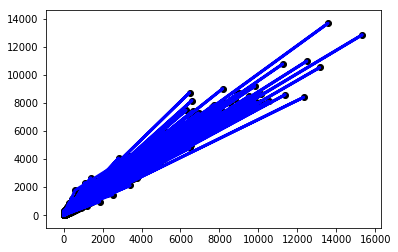

In [57]:
#RMSE Score
rmse = math.sqrt(metrics.mean_squared_error(y_validate, y_validate_pred))
print('RMSE:' , rmse)

print(forest.feature_importances_)
list(zip(X_train.columns, forest.feature_importances_))
plt.plot(y_validate, y_validate_pred, color = 'blue', linewidth = 3)
plt.scatter(y_validate, y_validate_pred,  color = 'black')

In [58]:
err=[]
y_pred_train_tot = []
y_pred_test_tot = []

kfold = StratifiedKFold(n_splits = 5,shuffle = True,random_state = 89)

for train_index, validate_index in kfold.split(train_predictors, label):
    print(train_index.shape, validate_index.shape)
    X_train_cv, X_validate_cv = train_predictors.iloc[train_index], train_predictors.iloc[validate_index]
    y_train_cv, y_validate_cv = label[train_index], label[validate_index]
    
    # training with early stop
    forest = RandomForestRegressor(**rf_params, random_state = 89)
    rf_model5 = forest.fit(X_train_cv, y_train_cv)
    pred_train = rf_model5.predict(train_predictors)
    pred_test = rf_model5.predict(test_predictors)
    
    y_pred_train_tot.append(pred_train)
    y_pred_test_tot.append(pred_test)

y_train_pred = np.mean(y_pred_train_tot,0)
y_test_pred = np.mean(y_pred_test_tot,0)
y_test_pred


(365158,) (91390,)
(365055,) (91493,)
(364876,) (91672,)
(365466,) (91082,)
(365637,) (90911,)


array([119.22, 120.74, 154.83, ..., 267.19, 414.57, 315.69])

In [59]:
y_train_pred = np.mean(y_pred_train_tot,0)
y_test_pred = np.mean(y_pred_test_tot,0)
y_test_pred

array([119.22, 120.74, 154.83, ..., 267.19, 414.57, 315.69])

In [60]:
stack_train['num_orders_RF'] = y_train_pred
stack_test['num_orders_RF'] = y_test_pred

test_dataset['num_orders'] = y_test_pred
# Output the Dataframe into a CSV file
test_dataset[['id', 'num_orders']].to_csv('Dataset/Submission_Anupam_RF.csv',  index = False)
test_dataset.drop('num_orders', axis = 1, inplace = True)

In [61]:
stack_train.head(20)

,id,num_orders,num_orders_LGBM,num_orders_CB,num_orders_RF
0,1379560,177.0,226.421388,275.634940,221.44
1,1466964,270.0,256.127585,264.344071,235.53
2,1346989,189.0,196.687989,238.918733,189.45
3,1338232,54.0,78.922301,66.934899,39.54
4,1448490,40.0,70.133334,72.197283,58.96
5,1270037,28.0,64.758090,64.555583,36.88
6,1191377,190.0,234.185081,175.933854,199.57
7,1499955,391.0,308.606828,326.635344,346.00
8,1025244,472.0,461.213800,438.365558,430.75
9,1054194,676.0,633.156564,654.676565,644.45


## XG Boost

In [62]:
import xgboost as xgb

In [63]:
xgb_train_dmatrix = xgb.DMatrix(X_train, label = y_train)
xgb_validate_dmatrix = xgb.DMatrix(X_validate, label = y_validate)
xgb_train_all_dmatrix = xgb.DMatrix(train_predictors)
xgb_test_dmatrix = xgb.DMatrix(test_predictors)

In [64]:
xgb_params = {'booster':'gbtree', 
          'eta': 0.002,
          'max_depth': 6,
          'min_child_weight': 8,
          'subsample': 0.9,
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'objective': 'reg:linear',
          'metrics': {'mae', 'rmse'},
          'nthread':8,
          'random_state': 89, 
          'silent': True
         }


In [65]:
%time cv_results = xgb.cv(xgb_params, xgb_train_dmatrix, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 10)
cv_results['test-rmse-mean'].min()

Wall time: 18min 45s


185.46500559999998

In [66]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
995,180.147864,1.124926,185.706839,7.063181
996,180.079926,1.124250,185.645306,7.064976
997,180.014114,1.128489,185.585059,7.062134
998,179.947171,1.127030,185.523831,7.061828
999,179.884067,1.126346,185.465006,7.060444


In [67]:
# We now make various combinations of max_depth and min_child_weight. During cross validation, we shall test RMSE \
# against each of these combinations and find out which one gives the least RMSE
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2,5)
    for min_child_weight in range(1,3)
]
# Define initial best params, MAE & RMSE. Westart with MAE and RMSE as infinity and as we get lower value, we keep updating it
min_mae = float("Inf")
min_rmse = float("Inf")
best_params = None

#Now we run CV for each combination of max_depth and min_child_weight
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    # Run CV
    cv_results = xgb.cv(params, xgb_train_dmatrix, seed = 89, nfold = 5, metrics = {'mae', 'rmse'}, early_stopping_rounds = 10)
    
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} rmse {} for {} rounds".format(mean_mae, mean_rmse, boost_rounds))
    
    #If MAE and RMSE value comes lower than previous minimum, update the minimum values
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
        
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight)
        
print("Best params: max_depth: {}, min_child_weight: {}, MAE: {}, RMSE: {}".format(best_params[0], best_params[1], min_mae, min_rmse)) 

CV with max_depth=2, min_child_weight=1
[23:31:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:31:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:31:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[23:32:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:32:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:32:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:32:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:32:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

In [68]:
#Now update the params from the best parameters of Cross Validation
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]
params

{'max_depth': 4, 'min_child_weight': 2, 'min_samples_split': array([2, 3])}

In [69]:
from sklearn.model_selection import KFold,StratifiedKFold
err=[]
y_pred_train_tot=[]
y_pred_test_tot=[]

kfold = StratifiedKFold(n_splits = 5,shuffle = True,random_state = 89)

for train_index, validate_index in kfold.split(train_predictors, label):
    print(train_index.shape, validate_index.shape)
    X_train_cv, X_validate_cv = train_predictors.iloc[train_index], train_predictors.iloc[validate_index]
    y_train_cv, y_validate_cv = label[train_index], label[validate_index]
    
    xgb_train_dmatrix = xgb.DMatrix(X_train_cv, label = y_train_cv)
    xgb_validate_dmatrix = xgb.DMatrix(X_validate_cv, label = y_validate_cv)
        
    xgb_model5 = xgb.train(params, xgb_train_dmatrix, 400, verbose_eval = 1)
        
    preds = xgb_model5.predict(xgb_validate_dmatrix)
    rmse = math.sqrt(metrics.mean_squared_error(y_validate_cv,preds))
    print("RMSE: ",rmse)
    err.append(rmse)
    
    pred_train = xgb_model5.predict(xgb_train_all_dmatrix, ntree_limit = xgb_model5.best_ntree_limit)
    pred_test = xgb_model5.predict(xgb_test_dmatrix, ntree_limit = xgb_model5.best_ntree_limit)
    
    y_pred_train_tot.append(pred_train)
    y_pred_test_tot.append(pred_test)

(365158,) (91390,)
[23:33:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc

[23:33:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:33:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:34:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:34:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:34:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:34:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:34:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:34:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:34:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:34:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:34:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:35:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:35:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:35:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:35:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:36:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:36:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:36:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:36:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:36:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:36:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:37:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:37:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:37:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:37:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[23:37:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:37:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:37:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:37:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:37:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:38:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:38:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:39:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:39:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:39:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:39:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:39:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[23:40:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:40:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:40:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:40:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:40:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:40:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:40:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:40:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:41:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:41:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:41:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:41:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:41:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:41:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:41:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:41:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:41:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:42:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:42:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:42:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:42:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:42:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:42:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:42:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:42:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:42:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:42:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:43:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:43:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:43:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:43:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:44:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:44:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:44:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:44:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:44:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:44:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:44:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:45:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[23:45:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:45:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:45:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:45:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

In [70]:
y_train_pred = np.mean(y_pred_train_tot,0)
y_test_pred = np.mean(y_pred_test_tot,0)

In [71]:
stack_train['num_orders_XGB'] = y_train_pred
stack_test['num_orders_XGB'] = y_test_pred

test_dataset['num_orders_XGB'] = y_test_pred
# Output the Dataframe into a CSV file
test_dataset[['id', 'num_orders_XGB']].to_csv('Dataset/Submission_Anupam_XGB.csv',  index = False)
test_dataset.drop('num_orders_XGB', axis = 1, inplace = True)

In [72]:
stack_train.head(20)

,id,num_orders,num_orders_LGBM,num_orders_CB,num_orders_RF,num_orders_XGB
0,1379560,177.0,226.421388,275.634940,221.44,226.936478
1,1466964,270.0,256.127585,264.344071,235.53,322.962769
2,1346989,189.0,196.687989,238.918733,189.45,158.993881
3,1338232,54.0,78.922301,66.934899,39.54,71.173729
4,1448490,40.0,70.133334,72.197283,58.96,39.216270
5,1270037,28.0,64.758090,64.555583,36.88,39.585651
6,1191377,190.0,234.185081,175.933854,199.57,198.322510
7,1499955,391.0,308.606828,326.635344,346.00,246.976776
8,1025244,472.0,461.213800,438.365558,430.75,455.239166
9,1054194,676.0,633.156564,654.676565,644.45,613.424072


#### Now Output the Train & Test Stack file. This will be used by the final model to make final prediction

In [73]:
# Output the train & test stack Dataframe into a CSV file
stack_train.to_csv('Dataset/Stack_Train.csv',  index = False)
stack_test.to_csv('Dataset/Stack_Test.csv',  index = False)